# llc4320 drifters spectra: Lagrangian vs Eulerian

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd
from xhistogram.xarray import histogram
import xskillscore as xs
%matplotlib inline
from matplotlib import pyplot as plt
from cmocean import cm
import matplotlib.colors as colors

import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.drifters as dr

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.7169332.datarmor0/parcels-502027/libparcels_random_9f987b2e-cdb7-4caf-bae5-c37f4d510103.so


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    cluster = PBSCluster(cores=28, processes=14) # necessary?
    w = cluster.scale(jobs=1)
    # 3 needed for lagrangian lon/lat binning
    # 15 for eulerian binning
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
client

Client Scheduler: tcp://10.148.0.251:34965 Dashboard: http://10.148.0.251:8787/status,Cluster Workers: 14 Cores: 28 Memory: 111.72 GiB


__________________
# 2. Band-integrated KE

In [4]:
# KE already computed from 2D binned spectra
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_T365j_dt1j_dij50'
p = pa.parcels_output(root_dir+run_name, parquets=['trajectory'])
E = p.load_diagnostic('spectra_uv_T60_mean0_lat_lon_bands.zarr')
E_L = E.E

E = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60_lat_lon_bands_from_2Dbin_spectra.zarr'))
E_E = E.E_SSUV
E_E

,Array,Chunk
Bytes,4.89 MiB,10.55 kiB
Shape,"(15, 359, 119)","(1, 45, 30)"
Count,481 Tasks,480 Chunks
Type,float64,numpy.ndarray


In [5]:
# load raw spectra (zonally averaged)
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50_XCYC'
p = pa.parcels_output(root_dir+run_name, parquets=['trajectory'])
ds_L = (p.load_diagnostic('spectra_uv_T60_mean0_lat.zarr') # should change to not 2D binned spectra, not done yet
        .rename({'E':'E_Lagrangian'})
       )

ds_E = (xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60_lat.zarr'))
        .rename({'E_SSUV_T60': 'E_Eulerian'})
       )

ds = xr.merge([ds_L, ds_E])

E_Lagrangian = ds.E_Lagrangian
E_Eulerian = ds.E_Eulerian
df=E_Eulerian.frequency[1]-E_Eulerian.frequency[0]
# Inertial frequency
f_llc = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_Eulerian.lat_bins))
f_cpd_llc = f_llc*86400/2./np.pi
E_Lagrangian

<xarray.DataArray 'E_Lagrangian' (lat_bins: 119, frequency: 1440)>
dask.array<open_dataset-a00d3e8ae4220d66a421b759b8120dfdE, shape=(119, 1440), dtype=float64, chunksize=(60, 720), chunktype=numpy.ndarray>
Coordinates:
  * frequency  (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * lat_bins   (lat_bins) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5

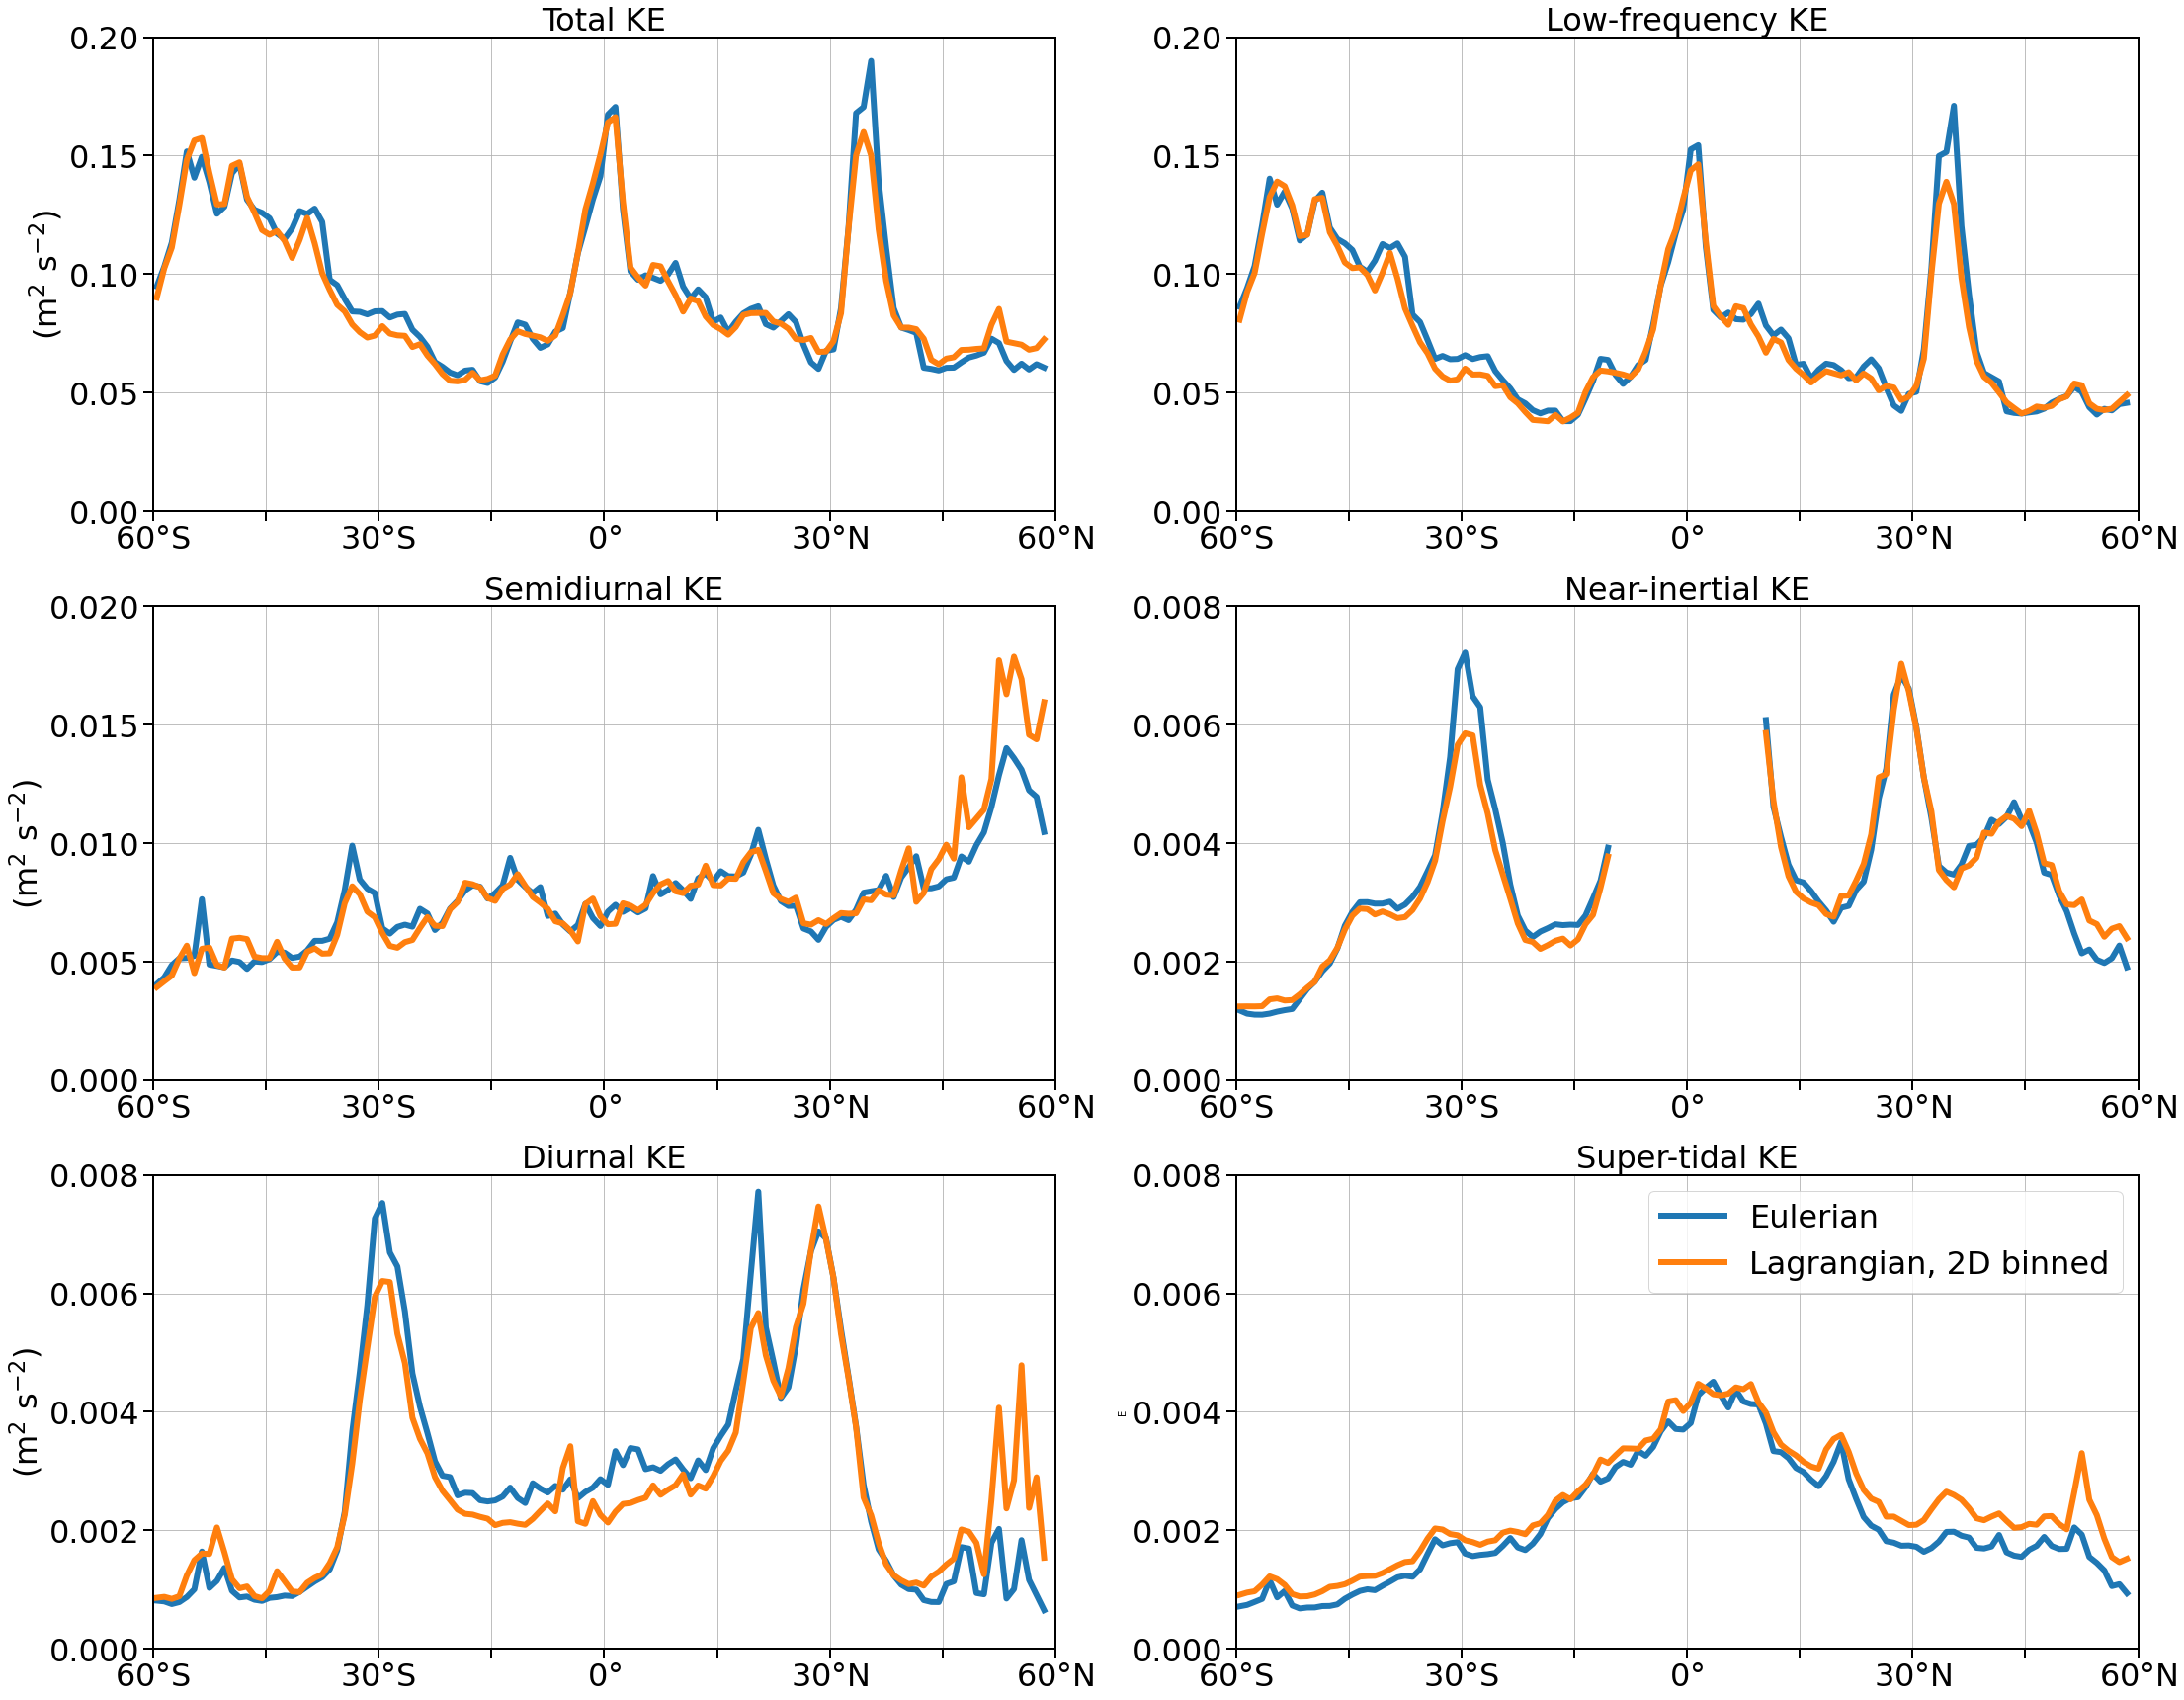

In [10]:
from pylab import *
rc('axes', linewidth=2)

labels = ['Eulerian', 'Lagrangian, 2D binned']
linewidth = 6
fontsize = 32
upper_limit= 0.2

fig, ax = plt.subplots(figsize=(36,30))

ax = plt.subplot(321)
E_E.sel(frequency_band='total').mean('lon_bins').plot(label=labels[0], linewidth=linewidth) # total energy
E_L.sel(frequency_band='total').mean('lon_bins').plot(label=labels[1], linewidth=linewidth) # total energy
#ax.legend(prop={'size': fontsize}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -45., -30., -15, 0., 15., 30., 45., 60.])
ax.set_xticklabels(['$60\degree$S','','$30\degree$S','','$0\degree$','','$30\degree$N','','$60\degree$N'])
ax.set_ylim([0,0.2])
# Label, size
ax.set_xlabel('',fontsize=fontsize)
ax.set_ylabel('',fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title('Total KE',fontsize=fontsize)
ax.set_ylabel('(m$^2$ s$^{-2}$)',fontsize=fontsize)
ax.tick_params(direction='out', length=10, width=2)

ax = plt.subplot(322)
E_E.sel(frequency_band='low').mean('lon_bins').plot(label=labels[1], linewidth=linewidth) # low energy
E_L.sel(frequency_band='low').mean('lon_bins').plot(label=labels[1], linewidth=linewidth) # low energy
#ax.legend(prop={'size': fontsize}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -45., -30., -15, 0., 15., 30., 45., 60.])
ax.set_xticklabels(['$60\degree$S','','$30\degree$S','','$0\degree$','','$30\degree$N','','$60\degree$N'])
ax.set_ylim([0,0.2])
# Label, size
ax.set_xlabel('',fontsize=fontsize)
ax.set_ylabel('',fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title('Low-frequency KE',fontsize=fontsize)
ax.tick_params(direction='out', length=10, width=2)

ax = plt.subplot(323)
E_E.sel(frequency_band='semidiurnal_0dot4').mean('lon_bins').plot(label=labels[0], linewidth=linewidth) # energy around semi-diurnal frequencies
E_L.where(E_L<upper_limit).sel(frequency_band='semidiurnal_0dot4').mean('lon_bins').plot(label=labels[1], linewidth=linewidth) # energy around semi-diurnal frequencies
#ax.legend(prop={'size': fontsize}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -45., -30., -15, 0., 15., 30., 45., 60.])
ax.set_xticklabels(['$60\degree$S','','$30\degree$S','','$0\degree$','','$30\degree$N','','$60\degree$N'])
ax.set_ylim([0,0.02])
ax.set_xlabel('',fontsize=fontsize)
ax.set_ylabel('(m$^2$ s$^{-2}$)',fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title('Semidiurnal KE',fontsize=fontsize)
ax.tick_params(direction='out', length=10, width=2)

ax = plt.subplot(324)
E_E.sel(frequency_band='inertial_0dot1').mean('lon_bins').where(abs(E_L.lat_bins)>10).plot(label=labels[0], linewidth=linewidth) # energy around f
E_L.sel(frequency_band='inertial_0dot1').mean('lon_bins').where(abs(E_L.lat_bins)>10).plot(label=labels[1], linewidth=linewidth) # energy around f
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -45., -30., -15, 0., 15., 30., 45., 60.])
ax.set_xticklabels(['$60\degree$S','','$30\degree$S','','$0\degree$','','$30\degree$N','','$60\degree$N'])
ax.set_ylim([0,0.008])
ax.set_xlabel('',fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title('Near-inertial KE',fontsize=fontsize)
ax.set_ylabel('',fontsize=fontsize)
ax.tick_params(direction='out', length=10, width=2)

ax = plt.subplot(325)
E_E.sel(frequency_band='diurnal_0dot1').mean('lon_bins').plot(label=labels[0], linewidth=linewidth) # energy around diurnal frequencies
E_L.sel(frequency_band='diurnal_0dot1').mean('lon_bins').plot(label=labels[1], linewidth=linewidth) # energy around diurnal frequencies
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -45., -30., -15, 0., 15., 30., 45., 60.])
ax.set_xticklabels(['$60\degree$S','','$30\degree$S','','$0\degree$','','$30\degree$N','','$60\degree$N'])
ax.set_ylim([0,0.008])
ax.set_xlabel('',fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title('Diurnal KE',fontsize=fontsize)
ax.set_ylabel('(m$^2$ s$^{-2}$)',fontsize=fontsize)
ax.tick_params(direction='out', length=10, width=2)

ax = plt.subplot(326)
E_E.sel(frequency_band='supertidal').mean('lon_bins').plot(label=labels[0], linewidth=linewidth) # energy around diurnal frequencies
E_L.sel(frequency_band='supertidal').mean('lon_bins').plot(label=labels[1], linewidth=linewidth) # energy around diurnal frequencies
ax.grid()
ax.legend(prop={'size': fontsize}); 
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -45., -30., -15, 0., 15., 30., 45., 60.])
ax.set_xticklabels(['$60\degree$S','','$30\degree$S','','$0\degree$','','$30\degree$N','','$60\degree$N'])
ax.set_ylim([0,0.008])
ax.set_xlabel('',fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title('Super-tidal KE',fontsize=fontsize)
ax.tick_params(direction='out', length=10, width=2)

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Band_integral_LLC_Eulerian_vs_Lagrangian_bin.png',dpi=300)

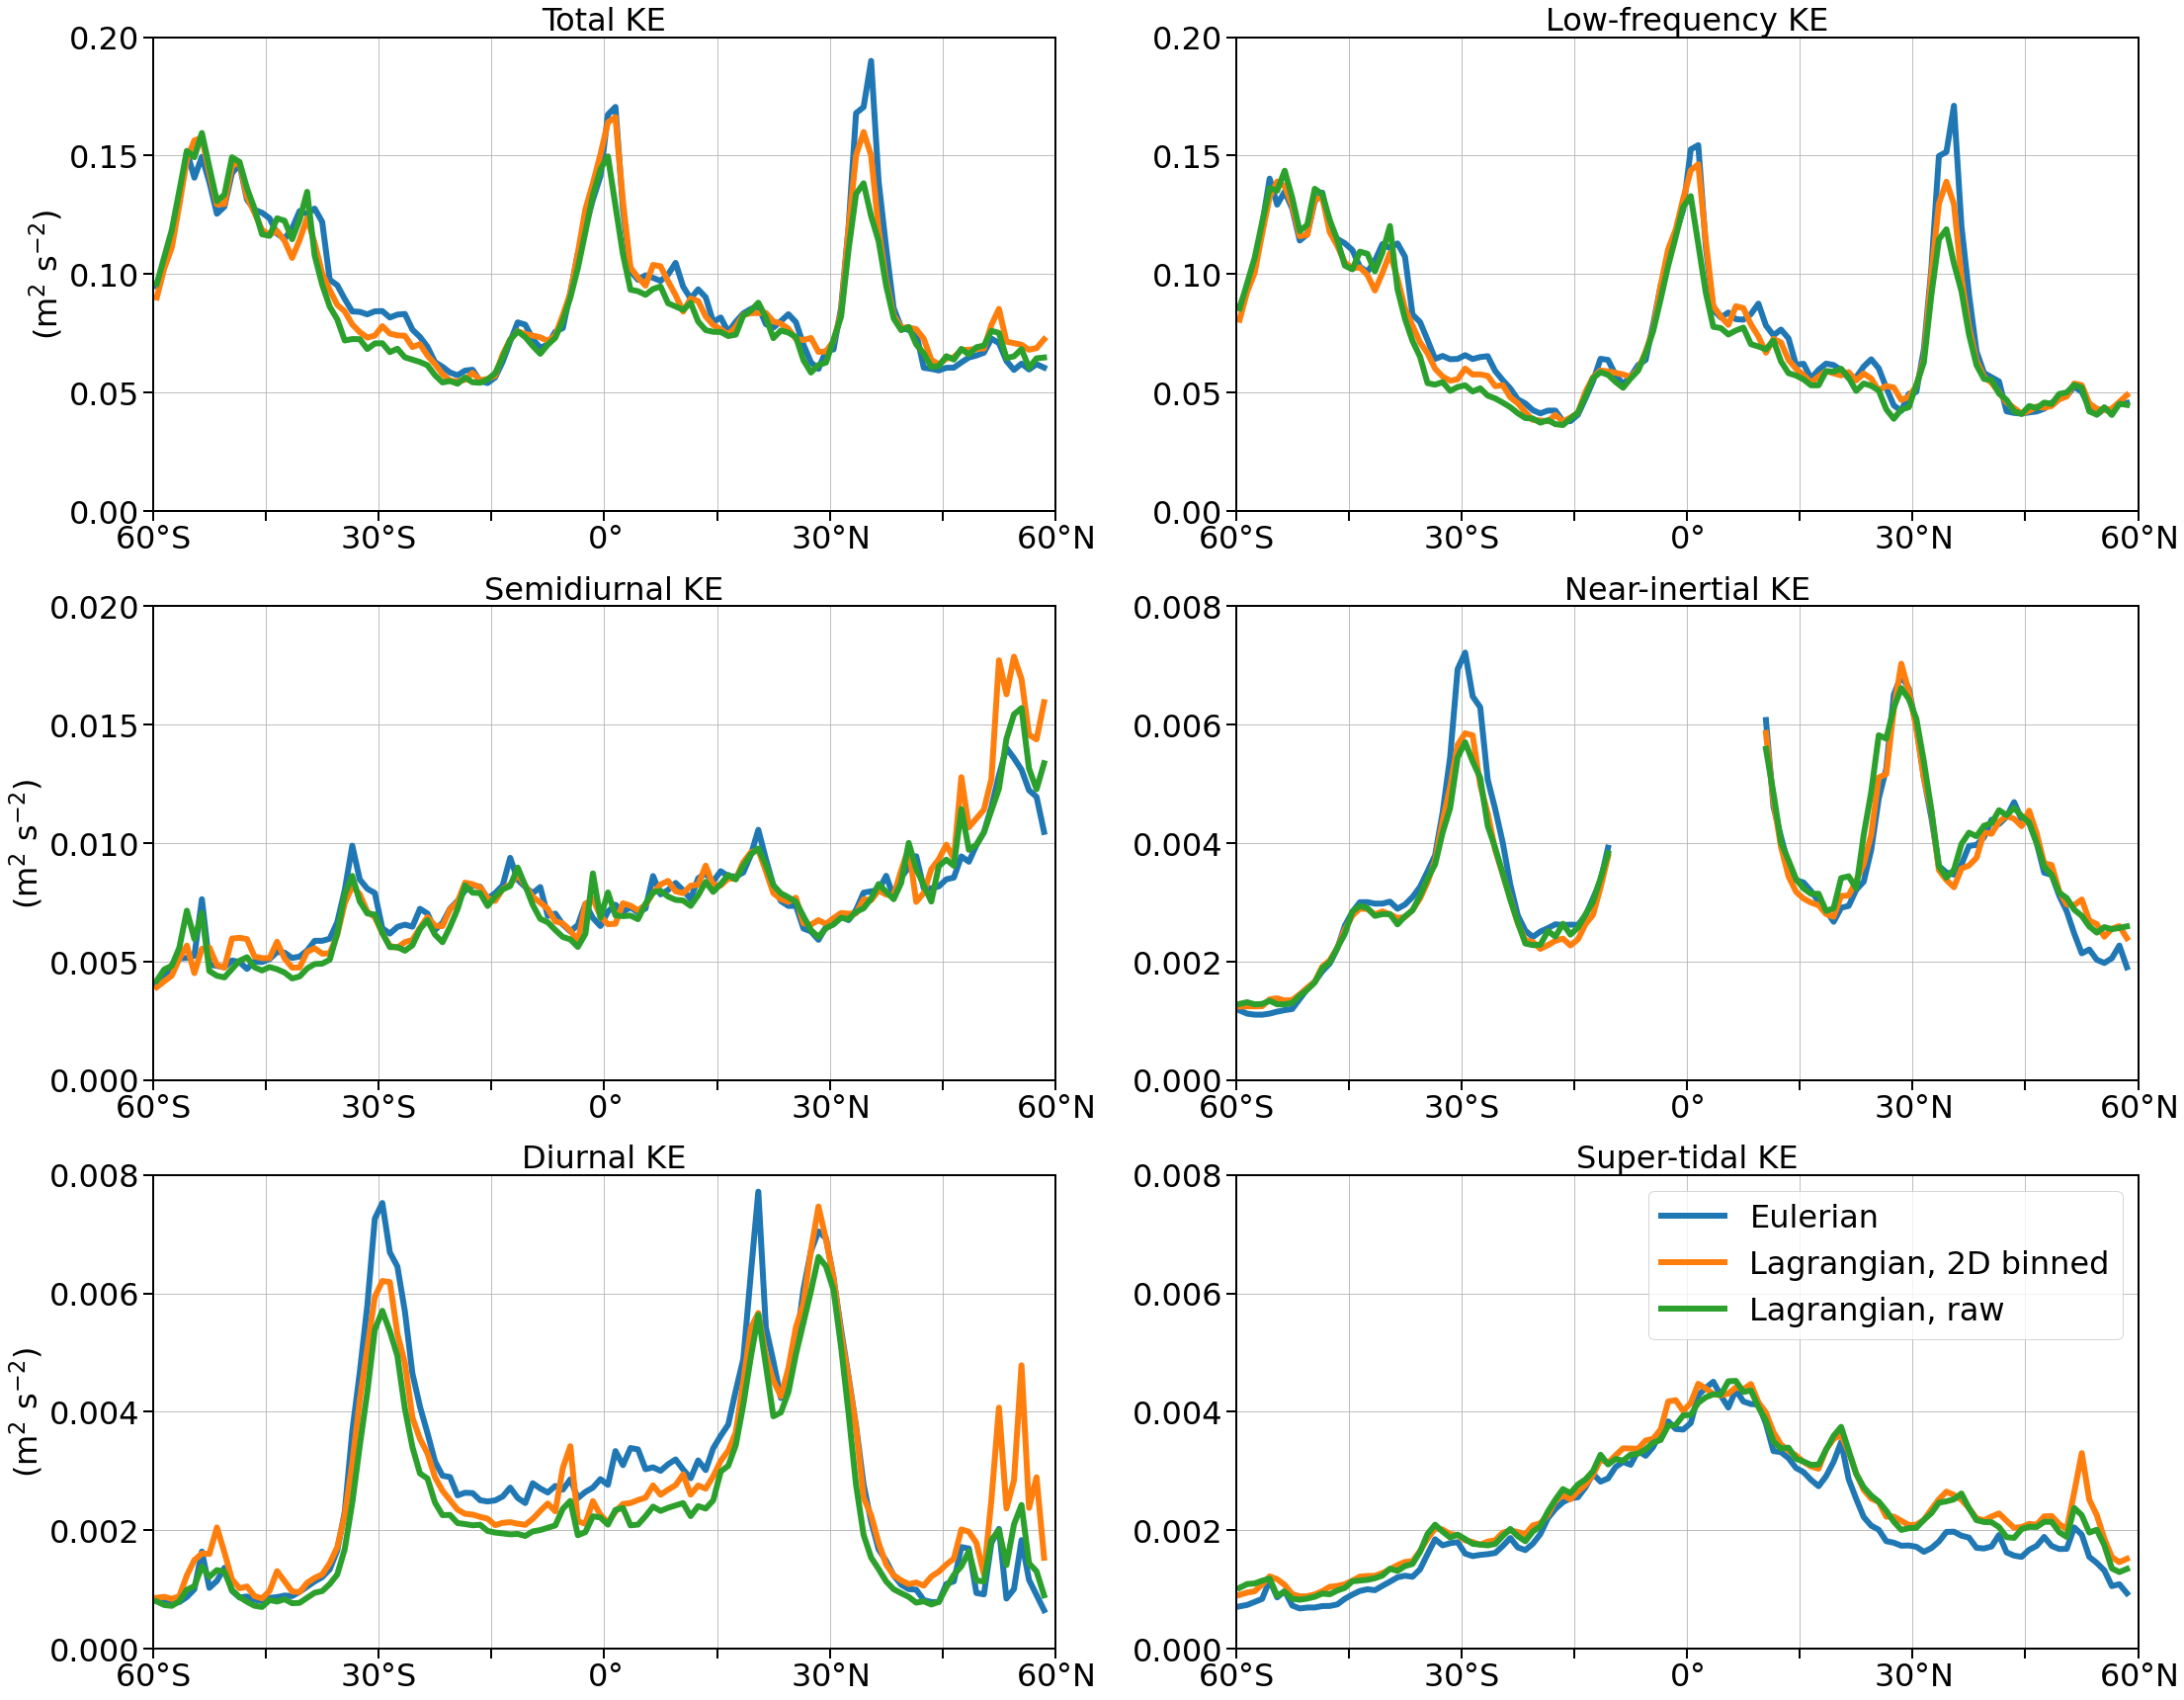

In [6]:
from pylab import *
rc('axes', linewidth=2)

labels = ['Eulerian', 'Lagrangian, 2D binned', 'Lagrangian, raw']
linewidth = 6
fontsize = 32
upper_limit= 0.2

fig, ax = plt.subplots(figsize=(36,30))

ax = plt.subplot(321)
E_E.sel(frequency_band='total').mean('lon_bins').plot(label=labels[0], linewidth=linewidth) # total energy
E_L.sel(frequency_band='total').mean('lon_bins').plot(label=labels[1], linewidth=linewidth) # total energy
(E_Lagrangian*df).sum(dim='frequency').plot(label=labels[2], linewidth=linewidth) # total energy
#ax.legend(prop={'size': fontsize}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -45., -30., -15, 0., 15., 30., 45., 60.])
ax.set_xticklabels(['$60\degree$S','','$30\degree$S','','$0\degree$','','$30\degree$N','','$60\degree$N'])
ax.set_ylim([0,0.2])
# Label, size
ax.set_xlabel('',fontsize=fontsize)
ax.set_ylabel('',fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title('Total KE',fontsize=fontsize)
ax.set_ylabel('(m$^2$ s$^{-2}$)',fontsize=fontsize)
ax.tick_params(direction='out', length=10, width=2)

ax = plt.subplot(322)
E_E.sel(frequency_band='low').mean('lon_bins').plot(label=labels[1], linewidth=linewidth) # low energy
E_L.sel(frequency_band='low').mean('lon_bins').plot(label=labels[1], linewidth=linewidth) # low energy
(E_Lagrangian.where((abs(E_Lagrangian.frequency)<0.5) , other=0.)*df).sum(dim='frequency').plot(label=labels[1], linewidth=linewidth) # total energy
#ax.legend(prop={'size': fontsize}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -45., -30., -15, 0., 15., 30., 45., 60.])
ax.set_xticklabels(['$60\degree$S','','$30\degree$S','','$0\degree$','','$30\degree$N','','$60\degree$N'])
ax.set_ylim([0,0.2])
# Label, size
ax.set_xlabel('',fontsize=fontsize)
ax.set_ylabel('',fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title('Low-frequency KE',fontsize=fontsize)
ax.tick_params(direction='out', length=10, width=2)

ax = plt.subplot(323)
E_E.sel(frequency_band='semidiurnal_0dot4').mean('lon_bins').plot(label=labels[0], linewidth=linewidth) # energy around semi-diurnal frequencies
E_L.where(E_L<upper_limit).sel(frequency_band='semidiurnal_0dot4').mean('lon_bins').plot(label=labels[1], linewidth=linewidth) # energy around semi-diurnal frequencies
(E_Lagrangian.where((abs(E_Lagrangian.frequency)>1.6) & (abs(E_Lagrangian.frequency)<2.4) , other=0.)*df).sum(dim='frequency').plot(label=labels[2], linewidth=linewidth) # energy around semi-diurnal frequencies
#ax.legend(prop={'size': fontsize}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -45., -30., -15, 0., 15., 30., 45., 60.])
ax.set_xticklabels(['$60\degree$S','','$30\degree$S','','$0\degree$','','$30\degree$N','','$60\degree$N'])
ax.set_ylim([0,0.02])
ax.set_xlabel('',fontsize=fontsize)
ax.set_ylabel('(m$^2$ s$^{-2}$)',fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title('Semidiurnal KE',fontsize=fontsize)
ax.tick_params(direction='out', length=10, width=2)

ax = plt.subplot(324)
E_E.sel(frequency_band='inertial_0dot1').mean('lon_bins').where(abs(E_L.lat_bins)>10).plot(label=labels[2], linewidth=linewidth) # energy around f
E_L.sel(frequency_band='inertial_0dot1').mean('lon_bins').where(abs(E_L.lat_bins)>10).plot(label=labels[2], linewidth=linewidth) # energy around f
(E_Lagrangian.where(abs(E_Lagrangian.frequency+f_cpd_llc)<.1, other=0.)*df).sum(dim='frequency').where(abs(E_Lagrangian.lat_bins)>10).plot(label=labels[2], linewidth=linewidth) # energy around f
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -45., -30., -15, 0., 15., 30., 45., 60.])
ax.set_xticklabels(['$60\degree$S','','$30\degree$S','','$0\degree$','','$30\degree$N','','$60\degree$N'])
ax.set_ylim([0,0.008])
ax.set_xlabel('',fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title('Near-inertial KE',fontsize=fontsize)
ax.set_ylabel('',fontsize=fontsize)
ax.tick_params(direction='out', length=10, width=2)

ax = plt.subplot(325)
E_E.sel(frequency_band='diurnal_0dot1').mean('lon_bins').plot(label=labels[2], linewidth=linewidth) # energy around diurnal frequencies
E_L.sel(frequency_band='diurnal_0dot1').mean('lon_bins').plot(label=labels[2], linewidth=linewidth) # energy around diurnal frequencies
(E_Lagrangian.where((abs(E_Lagrangian.frequency)>0.9) & (abs(E_Lagrangian.frequency)<1.1) , other=0.)*df).sum(dim='frequency').plot(label=labels[2], linewidth=linewidth) # energy around diurnal frequencies
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -45., -30., -15, 0., 15., 30., 45., 60.])
ax.set_xticklabels(['$60\degree$S','','$30\degree$S','','$0\degree$','','$30\degree$N','','$60\degree$N'])
ax.set_ylim([0,0.008])
ax.set_xlabel('',fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title('Diurnal KE',fontsize=fontsize)
ax.set_ylabel('(m$^2$ s$^{-2}$)',fontsize=fontsize)
ax.tick_params(direction='out', length=10, width=2)

ax = plt.subplot(326)
E_E.sel(frequency_band='supertidal').mean('lon_bins').plot(label=labels[0], linewidth=linewidth) # energy around diurnal frequencies
E_L.sel(frequency_band='supertidal').mean('lon_bins').plot(label=labels[1], linewidth=linewidth) # energy around diurnal frequencies
(E_Lagrangian.where((abs(E_Lagrangian.frequency)>2.4), other=0.)*df).sum(dim='frequency').plot(label=labels[2], linewidth=linewidth) # energy around diurnal frequencies
ax.grid()
ax.legend(prop={'size': fontsize}); 
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -45., -30., -15, 0., 15., 30., 45., 60.])
ax.set_xticklabels(['$60\degree$S','','$30\degree$S','','$0\degree$','','$30\degree$N','','$60\degree$N'])
ax.set_ylim([0,0.008])
ax.set_xlabel('',fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title('Super-tidal KE',fontsize=fontsize)
ax.tick_params(direction='out', length=10, width=2)

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Band_integral_LLC_Eulerian_Lagrangian_bin_vs_raw.png',dpi=300)

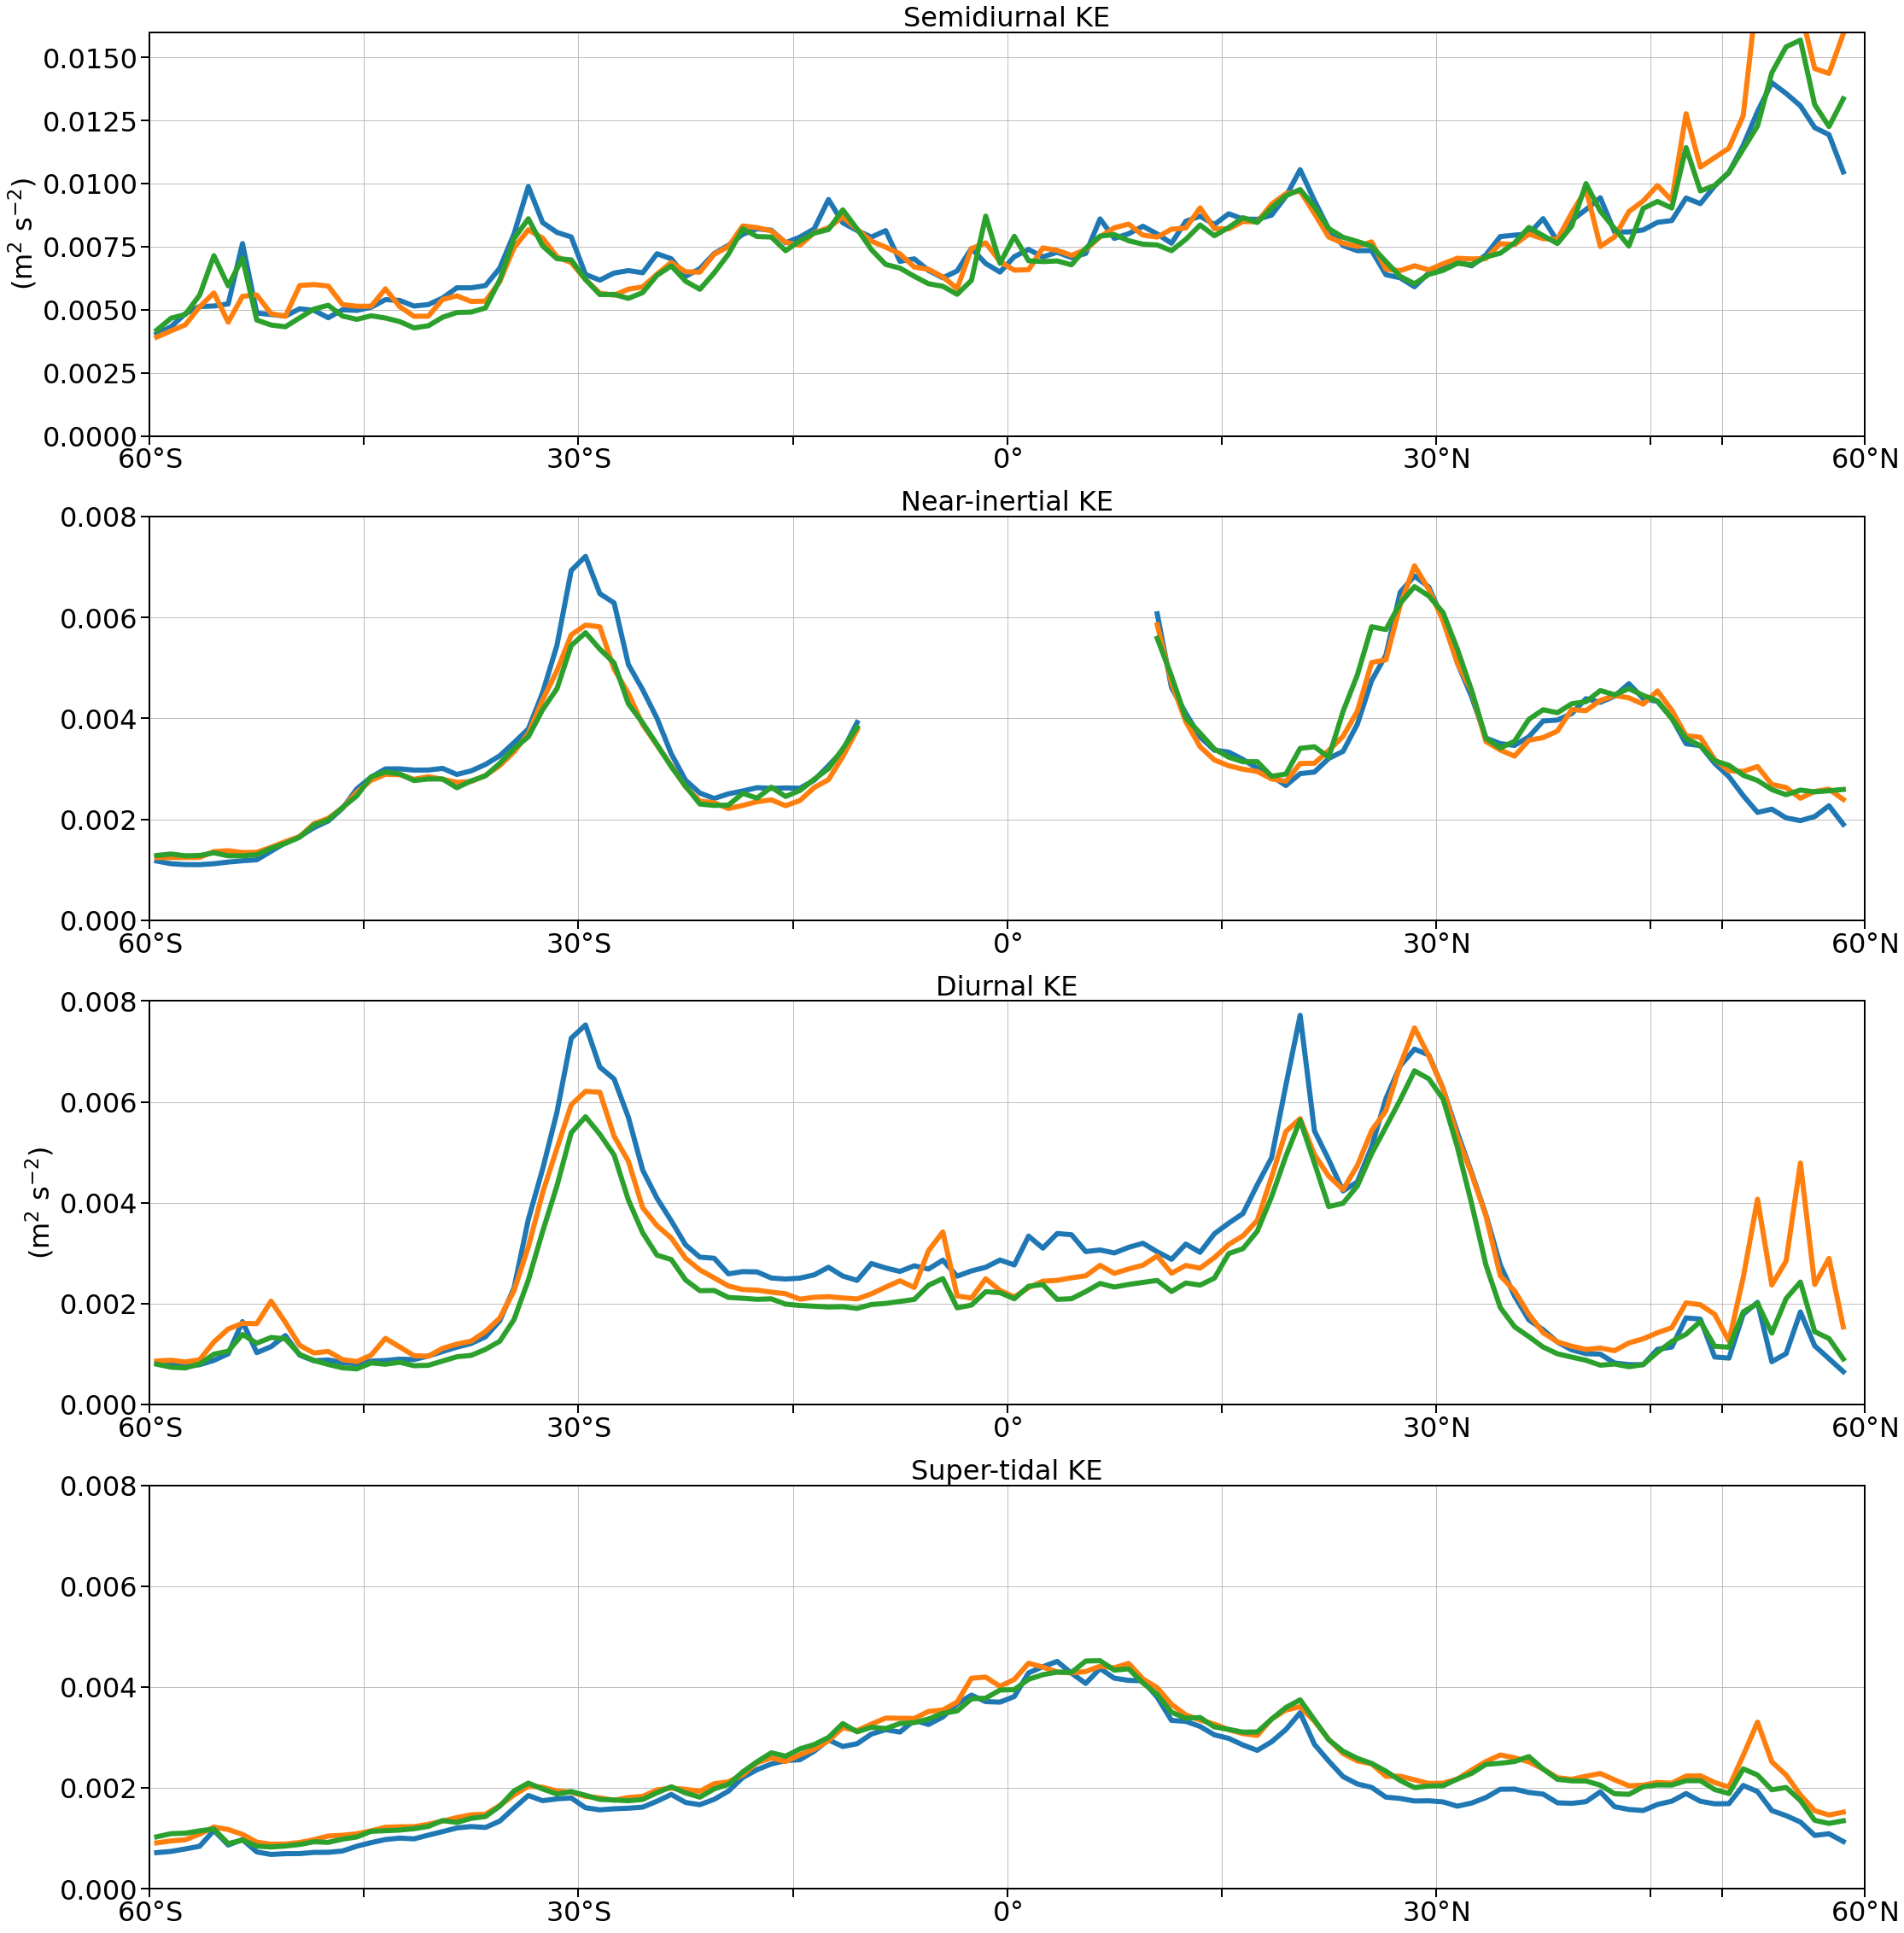

In [9]:
from pylab import *
rc('axes', linewidth=2)

labels = ['Eulerian', 'Lagrangian, 2D binned', 'Lagrangian, raw']
linewidth = 6
fontsize = 32
upper_limit= 0.2

fig, ax = plt.subplots(figsize=(36,40))

ax = plt.subplot(411)
E_E.sel(frequency_band='semidiurnal_0dot4').mean('lon_bins').plot(label=labels[0], linewidth=linewidth) # energy around semi-diurnal frequencies
E_L.where(E_L<upper_limit).sel(frequency_band='semidiurnal_0dot4').mean('lon_bins').plot(label=labels[1], linewidth=linewidth) # energy around semi-diurnal frequencies
(E_Lagrangian.where((abs(E_Lagrangian.frequency)>1.6) & (abs(E_Lagrangian.frequency)<2.4) , other=0.)*df).sum(dim='frequency').plot(label=labels[2], linewidth=linewidth) # energy around semi-diurnal frequencies
#ax.legend(prop={'size': fontsize}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -45., -30., -15, 0., 15., 30., 45., 50, 60.])
ax.set_xticklabels(['$60\degree$S','','$30\degree$S','','$0\degree$','','$30\degree$N','','','$60\degree$N'])
ax.set_ylim([0,0.016])
ax.set_xlabel('',fontsize=fontsize)
ax.set_ylabel('(m$^2$ s$^{-2}$)',fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title('Semidiurnal KE',fontsize=fontsize)
ax.tick_params(direction='out', length=10, width=2)

ax = plt.subplot(412)
E_E.sel(frequency_band='inertial_0dot1').mean('lon_bins').where(abs(E_L.lat_bins)>10).plot(label=labels[2], linewidth=linewidth) # energy around f
E_L.sel(frequency_band='inertial_0dot1').mean('lon_bins').where(abs(E_L.lat_bins)>10).plot(label=labels[2], linewidth=linewidth) # energy around f
(E_Lagrangian.where(abs(E_Lagrangian.frequency+f_cpd_llc)<.1, other=0.)*df).sum(dim='frequency').where(abs(E_Lagrangian.lat_bins)>10).plot(label=labels[2], linewidth=linewidth) # energy around f
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -45., -30., -15, 0., 15., 30., 45., 50, 60.])
ax.set_xticklabels(['$60\degree$S','','$30\degree$S','','$0\degree$','','$30\degree$N','','','$60\degree$N'])
ax.set_ylim([0,0.008])
ax.set_xlabel('',fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title('Near-inertial KE',fontsize=fontsize)
ax.set_ylabel('',fontsize=fontsize)
ax.tick_params(direction='out', length=10, width=2)

ax = plt.subplot(413)
E_E.sel(frequency_band='diurnal_0dot1').mean('lon_bins').plot(label=labels[2], linewidth=linewidth) # energy around diurnal frequencies
E_L.sel(frequency_band='diurnal_0dot1').mean('lon_bins').plot(label=labels[2], linewidth=linewidth) # energy around diurnal frequencies
(E_Lagrangian.where((abs(E_Lagrangian.frequency)>0.9) & (abs(E_Lagrangian.frequency)<1.1) , other=0.)*df).sum(dim='frequency').plot(label=labels[2], linewidth=linewidth) # energy around diurnal frequencies
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -45., -30., -15, 0., 15., 30., 45., 50, 60.])
ax.set_xticklabels(['$60\degree$S','','$30\degree$S','','$0\degree$','','$30\degree$N','','','$60\degree$N'])
ax.set_ylim([0,0.008])
ax.set_xlabel('',fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title('Diurnal KE',fontsize=fontsize)
ax.set_ylabel('(m$^2$ s$^{-2}$)',fontsize=fontsize)
ax.tick_params(direction='out', length=10, width=2)

ax = plt.subplot(414)
E_E.sel(frequency_band='supertidal').mean('lon_bins').plot(label=labels[0], linewidth=linewidth) # energy around diurnal frequencies
E_L.sel(frequency_band='supertidal').mean('lon_bins').plot(label=labels[1], linewidth=linewidth) # energy around diurnal frequencies
(E_Lagrangian.where((abs(E_Lagrangian.frequency)>2.4), other=0.)*df).sum(dim='frequency').plot(label=labels[2], linewidth=linewidth) # energy around diurnal frequencies
ax.grid()
#ax.legend(prop={'size': fontsize}); 
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -45., -30., -15, 0., 15., 30., 45., 50, 60.])
ax.set_xticklabels(['$60\degree$S','','$30\degree$S','','$0\degree$','','$30\degree$N','','','$60\degree$N'])
ax.set_ylim([0,0.008])
ax.set_xlabel('',fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_title('Super-tidal KE',fontsize=fontsize)
ax.tick_params(direction='out', length=10, width=2)



Text(0.5, 1.0, 'Lagrangian (raw)')

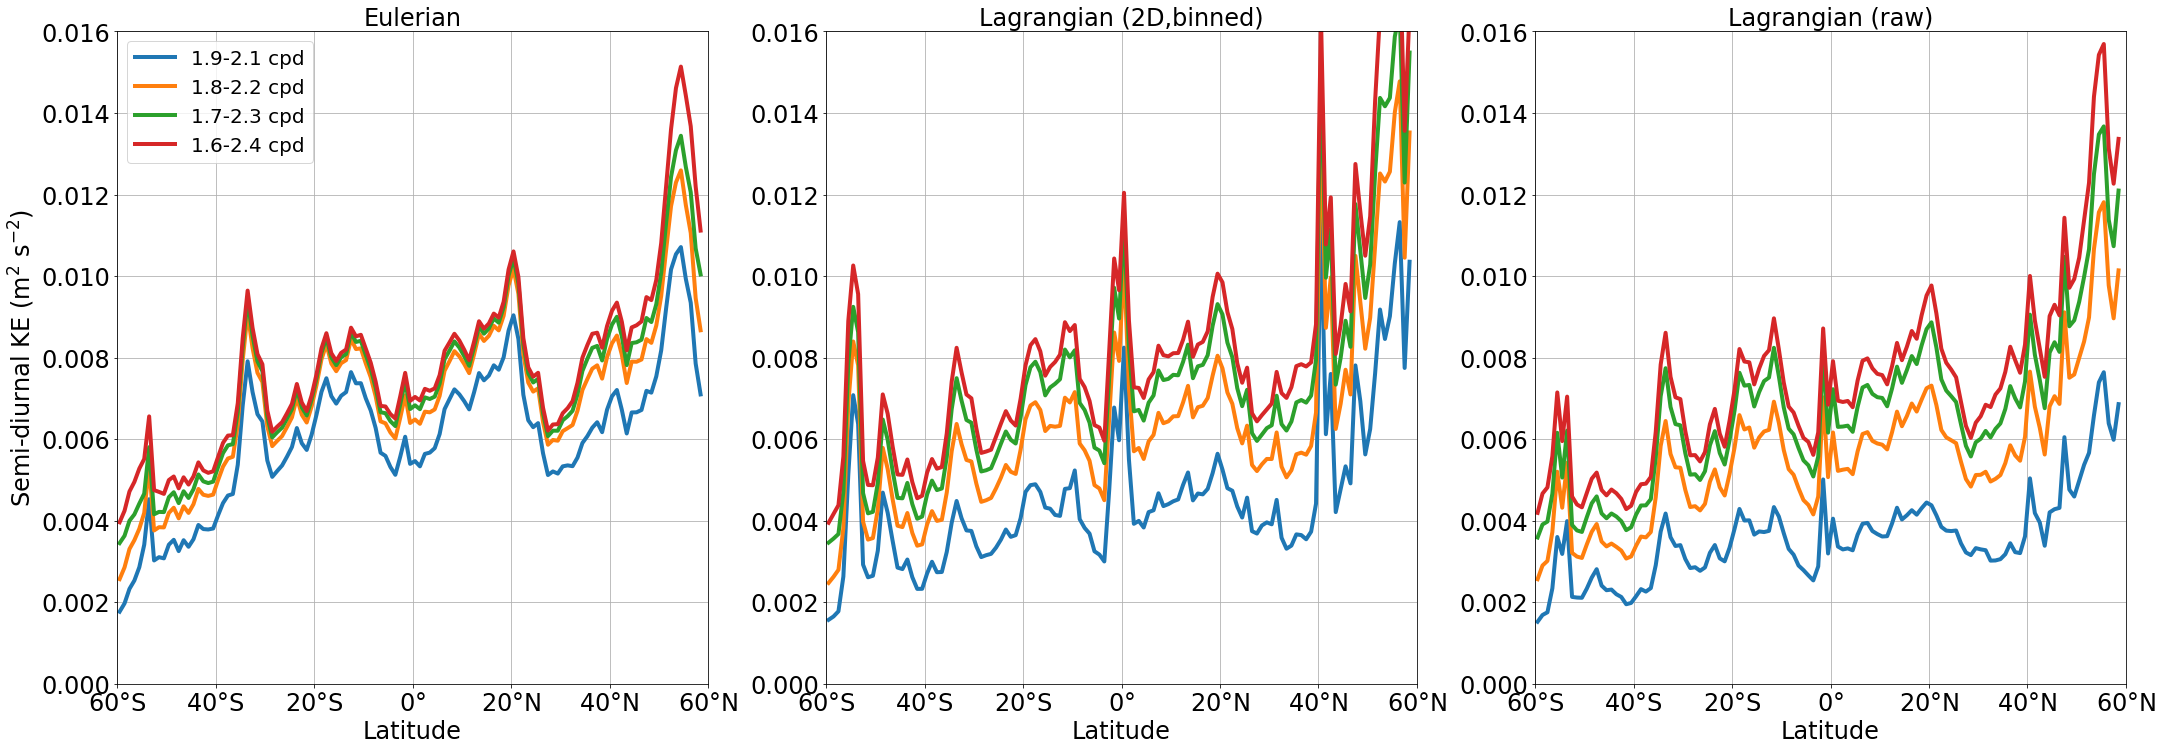

In [23]:
# Semi-diurnal
labels = ['1.9-2.1 cpd','1.8-2.2 cpd', '1.7-2.3 cpd', '1.6-2.4 cpd']

fig, ax = plt.subplots(figsize=(36,12))

ax = plt.subplot(1,3,1)
(E_Eulerian.where((abs(E_Eulerian.frequency)>1.9) & (abs(E_Eulerian.frequency)<2.1) , other=0.)*df).sum(dim='frequency').plot(label=labels[0], linewidth=4) # total energy
(E_Eulerian.where((abs(E_Eulerian.frequency)>1.8) & (abs(E_Eulerian.frequency)<2.2) , other=0.)*df).sum(dim='frequency').plot(label=labels[1], linewidth=4) # total energy
(E_Eulerian.where((abs(E_Eulerian.frequency)>1.7) & (abs(E_Eulerian.frequency)<2.3) , other=0.)*df).sum(dim='frequency').plot(label=labels[2], linewidth=4) # total energy
(E_Eulerian.where((abs(E_Eulerian.frequency)>1.6) & (abs(E_Eulerian.frequency)<2.4) , other=0.)*df).sum(dim='frequency').plot(label=labels[3], linewidth=4) # total energy
ax.legend(prop={'size': 20}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylim([0,0.016])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Semi-diurnal KE (m$^2$ s$^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('Eulerian',fontsize=24)

ax = plt.subplot(1,3,2)
E_L.sel(frequency_band='semidiurnal_0dot1').mean('lon_bins').plot(linewidth=4) # total energy
E_L.sel(frequency_band='semidiurnal_0dot2').mean('lon_bins').plot(linewidth=4) # total energy
E_L.sel(frequency_band='semidiurnal_0dot3').mean('lon_bins').plot(linewidth=4) # total energy
E_L.sel(frequency_band='semidiurnal_0dot4').mean('lon_bins').plot(linewidth=4) # total energy
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylim([0,0.016])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('Lagrangian (2D,binned)',fontsize=24)

ax = plt.subplot(1,3,3)
(E_Lagrangian.where((abs(E_Lagrangian.frequency)>1.9) & (abs(E_Eulerian.frequency)<2.1) , other=0.)*df).sum(dim='frequency').plot(label=labels[0], linewidth=4) # total energy
(E_Lagrangian.where((abs(E_Lagrangian.frequency)>1.8) & (abs(E_Eulerian.frequency)<2.2) , other=0.)*df).sum(dim='frequency').plot(label=labels[1], linewidth=4) # total energy
(E_Lagrangian.where((abs(E_Lagrangian.frequency)>1.7) & (abs(E_Eulerian.frequency)<2.3) , other=0.)*df).sum(dim='frequency').plot(label=labels[2], linewidth=4) # total energy
(E_Lagrangian.where((abs(E_Lagrangian.frequency)>1.6) & (abs(E_Eulerian.frequency)<2.4) , other=0.)*df).sum(dim='frequency').plot(label=labels[3], linewidth=4) # total energy
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylim([0,0.016])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('Lagrangian (raw)',fontsize=24)

#plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Band_integral_LLC_Eulerian_Lagrangian_each.png')

Text(0.5, 1.0, 'Lagrangian (raw)')

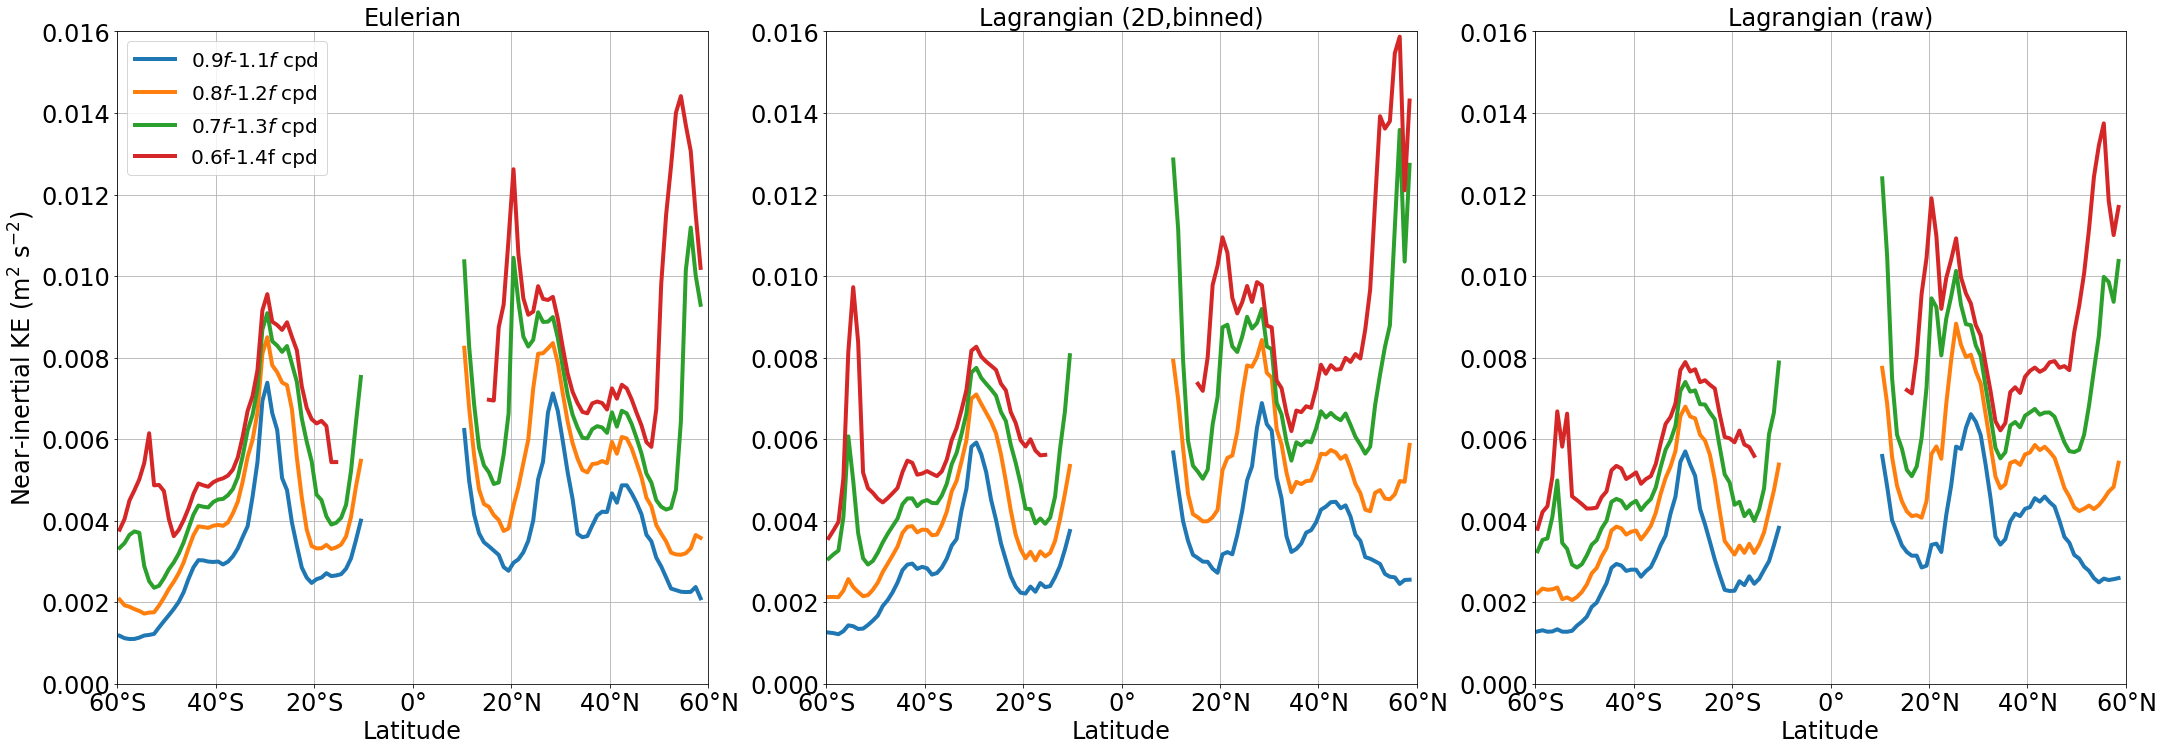

In [26]:
# Near-inertial
labels = ['0.9$f$-1.1$f$ cpd','0.8$f$-1.2$f$ cpd', '0.7$f$-1.3$f$ cpd', '0.6f-1.4f cpd']

fig, ax = plt.subplots(figsize=(36,12))

ax = plt.subplot(1,3,1)
(E_Eulerian.where(abs(E_Eulerian.frequency+f_cpd_llc)<.1, other=0.)*df).sum(dim='frequency').where(abs(E_Eulerian.lat_bins)>10).plot(label=labels[0], linewidth=4) # total energy
(E_Eulerian.where(abs(E_Eulerian.frequency+f_cpd_llc)<.2, other=0.)*df).sum(dim='frequency').where(abs(E_Eulerian.lat_bins)>10).plot(label=labels[1], linewidth=4) # total energy
(E_Eulerian.where(abs(E_Eulerian.frequency+f_cpd_llc)<.3, other=0.)*df).sum(dim='frequency').where(abs(E_Eulerian.lat_bins)>10).plot(label=labels[2], linewidth=4) # total energy
(E_Eulerian.where(abs(E_Eulerian.frequency+f_cpd_llc)<.4, other=0.)*df).sum(dim='frequency').where(abs(E_Eulerian.lat_bins)>15).plot(label=labels[3], linewidth=4) # total energy
ax.legend(prop={'size': 20}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylim([0,0.016])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Near-inertial KE (m$^2$ s$^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('Eulerian',fontsize=24)

ax = plt.subplot(1,3,2)
E_L.sel(frequency_band='inertial_0dot1').mean('lon_bins').where(abs(E_L.lat_bins)>10).plot(linewidth=4) # total energy
E_L.sel(frequency_band='inertial_0dot2').mean('lon_bins').where(abs(E_L.lat_bins)>10).plot(linewidth=4) # total energy
E_L.sel(frequency_band='inertial_0dot3').mean('lon_bins').where(abs(E_L.lat_bins)>10).plot(linewidth=4) # total energy
E_L.sel(frequency_band='inertial_0dot4').mean('lon_bins').where(abs(E_L.lat_bins)>15).plot(linewidth=4) # total energy
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylim([0,0.016])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('Lagrangian (2D,binned)',fontsize=24)

ax = plt.subplot(1,3,3)
(E_Lagrangian.where(abs(E_Lagrangian.frequency+f_cpd_llc)<.1, other=0.)*df).sum(dim='frequency').where(abs(E_Lagrangian.lat_bins)>10).plot(linewidth=4) # total energy
(E_Lagrangian.where(abs(E_Lagrangian.frequency+f_cpd_llc)<.2, other=0.)*df).sum(dim='frequency').where(abs(E_Lagrangian.lat_bins)>10).plot(linewidth=4) # total energy
(E_Lagrangian.where(abs(E_Lagrangian.frequency+f_cpd_llc)<.3, other=0.)*df).sum(dim='frequency').where(abs(E_Lagrangian.lat_bins)>10).plot(linewidth=4) # total energy
(E_Lagrangian.where(abs(E_Lagrangian.frequency+f_cpd_llc)<.4, other=0.)*df).sum(dim='frequency').where(abs(E_Lagrangian.lat_bins)>15).plot(linewidth=4) # total energy
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylim([0,0.016])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('Lagrangian (raw)',fontsize=24)

#plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Band_integral_LLC_Eulerian_Lagrangian_each.png')

Text(0.5, 1.0, 'Lagrangian (raw)')

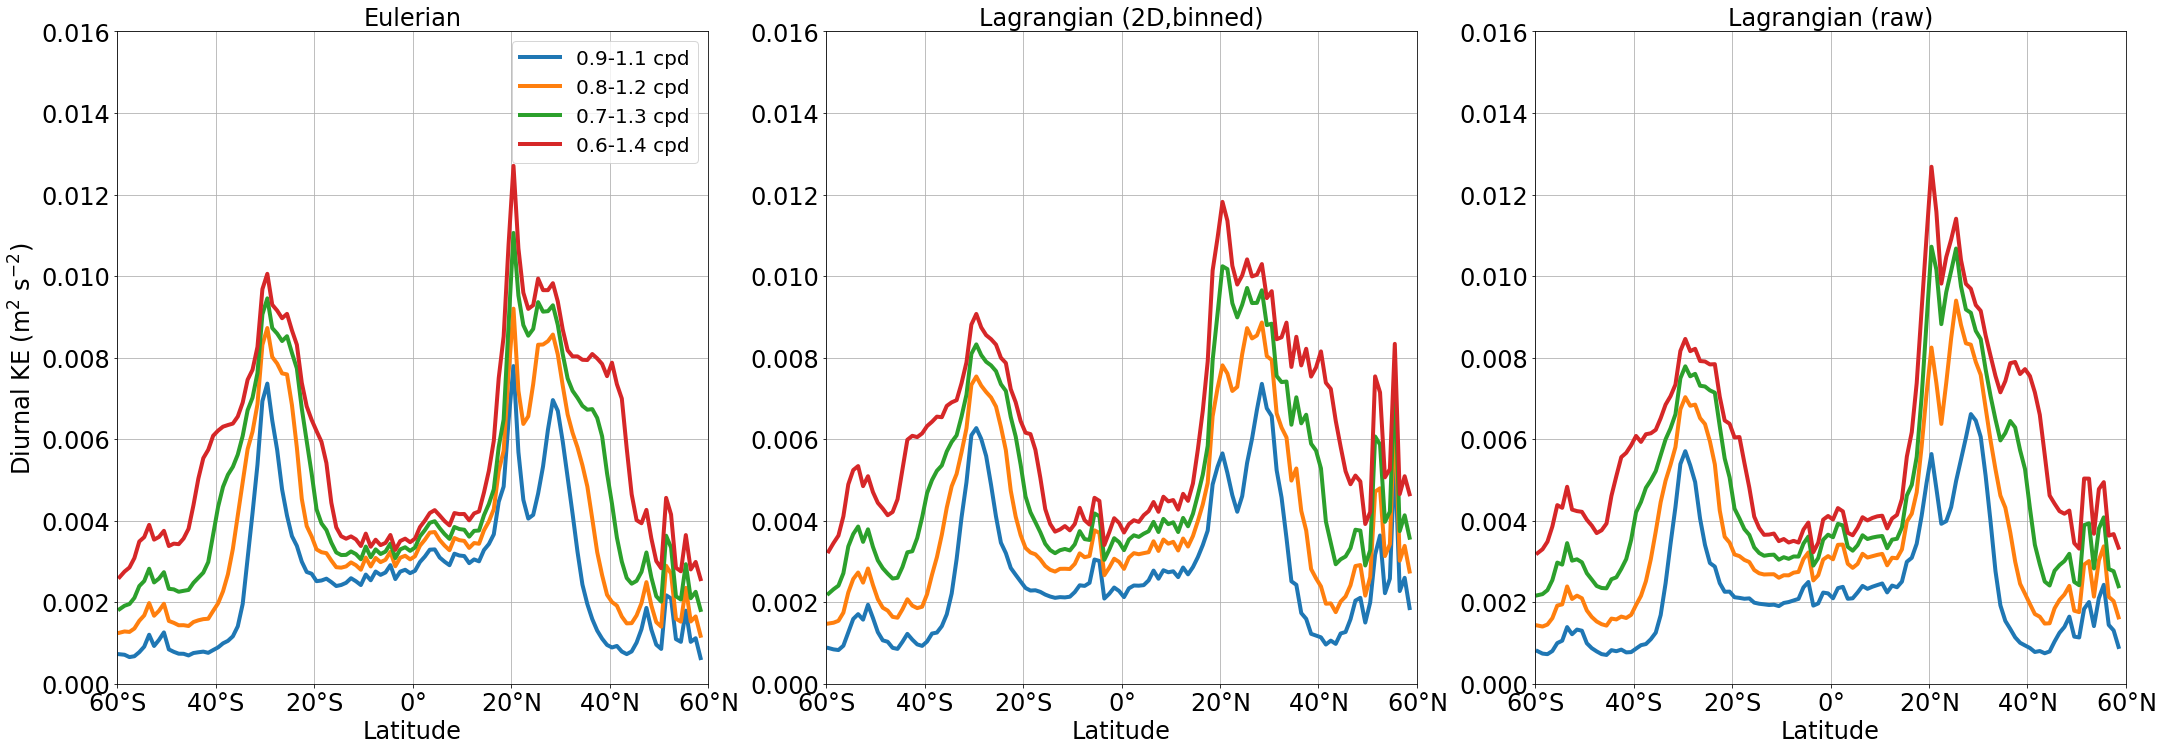

In [24]:
# Diurnal
labels = ['0.9-1.1 cpd','0.8-1.2 cpd', '0.7-1.3 cpd', '0.6-1.4 cpd']

fig, ax = plt.subplots(figsize=(36,12))

ax = plt.subplot(1,3,1)
(E_Eulerian.where((abs(E_Eulerian.frequency)>0.9) & (abs(E_Eulerian.frequency)<1.1) , other=0.)*df).sum(dim='frequency').plot(label=labels[0], linewidth=4) # total energy
(E_Eulerian.where((abs(E_Eulerian.frequency)>0.8) & (abs(E_Eulerian.frequency)<1.2) , other=0.)*df).sum(dim='frequency').plot(label=labels[1], linewidth=4) # total energy
(E_Eulerian.where((abs(E_Eulerian.frequency)>0.7) & (abs(E_Eulerian.frequency)<1.3) , other=0.)*df).sum(dim='frequency').plot(label=labels[2], linewidth=4) # total energy
(E_Eulerian.where((abs(E_Eulerian.frequency)>0.6) & (abs(E_Eulerian.frequency)<1.4) , other=0.)*df).sum(dim='frequency').plot(label=labels[3], linewidth=4) # total energy
ax.legend(prop={'size': 20}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylim([0,0.016])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Diurnal KE (m$^2$ s$^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('Eulerian',fontsize=24)

ax = plt.subplot(1,3,2)
E_L.sel(frequency_band='diurnal_0dot1').mean('lon_bins').plot(linewidth=4) # total energy
E_L.sel(frequency_band='diurnal_0dot2').mean('lon_bins').plot(linewidth=4) # total energy
E_L.sel(frequency_band='diurnal_0dot3').mean('lon_bins').plot(linewidth=4) # total energy
E_L.sel(frequency_band='diurnal_0dot4').mean('lon_bins').plot(linewidth=4) # total energy
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylim([0,0.016])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('Lagrangian (2D,binned)',fontsize=24)

ax = plt.subplot(1,3,3)
(E_Lagrangian.where((abs(E_Lagrangian.frequency)>0.9) & (abs(E_Eulerian.frequency)<1.1) , other=0.)*df).sum(dim='frequency').plot(label=labels[0], linewidth=4) # total energy
(E_Lagrangian.where((abs(E_Lagrangian.frequency)>0.8) & (abs(E_Eulerian.frequency)<1.2) , other=0.)*df).sum(dim='frequency').plot(label=labels[1], linewidth=4) # total energy
(E_Lagrangian.where((abs(E_Lagrangian.frequency)>0.7) & (abs(E_Eulerian.frequency)<1.3) , other=0.)*df).sum(dim='frequency').plot(label=labels[2], linewidth=4) # total energy
(E_Lagrangian.where((abs(E_Lagrangian.frequency)>0.6) & (abs(E_Eulerian.frequency)<1.4) , other=0.)*df).sum(dim='frequency').plot(label=labels[3], linewidth=4) # total energy
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylim([0,0.016])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('Lagrangian (raw)',fontsize=24)

#plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Band_integral_LLC_Eulerian_Lagrangian_each.png')

In [11]:
cluster.close()